<a href="https://colab.research.google.com/github/SiyiTang/LearningProcess/blob/main/MyPortfolio-first.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! /opt/bin/nvidia-smi

Fri Apr 23 14:48:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
pip install deepdow

     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 14.2MB 224kB/s 
     |████████████████████████████████| 2.2MB 35.0MB/s 
     |████████████████████████████████| 1.3MB 44.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 378kB 55.2MB/s 
     |████████████████████████████████| 153kB 56.4MB/s 
     |████████████████████████████████| 1.1MB 42.2MB/s 
     |████████████████████████████████| 163kB 57.1MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 81kB 11.9MB/s 
     |████████████████████████████████| 71kB 9.8MB/s 
  Created wheel for cvxpy: filename=cvxpy-1.1.12-cp37-cp37m-linux_x86_64.whl size=2731700 sha256=2fa82b0abbc053c973cbb91e38e8e34edc9968b83bdac64ac2958cf6e7a17f5b
  Stored in directory: /root/.cache/pip/wheels/9b

# Imports and Configuration

In [58]:
%matplotlib inline
from deepdow.benchmarks import Benchmark, OneOverN, Random, Singleton
from deepdow.callbacks import EarlyStoppingCallback, TensorBoardCallback
from deepdow.data import InRAMDataset, RigidDataLoader, prepare_standard_scaler, Scale
from deepdow.experiments import Run
from deepdow.nn import KeynesNet
from deepdow.layers import (AttentionCollapse, AverageCollapse, CovarianceMatrix, Conv, NumericalMarkowitz, MultiplyByConstant,
                     RNN, SoftmaxAllocator, WeightNorm)
from deepdow.losses import MeanReturns, SharpeRatio, MaximumDrawdown
from deepdow.visualize import generate_metrics_table, generate_weights_table, plot_metrics, plot_weight_heatmap
from deepdow.utils import raw_to_Xy
import matplotlib.pyplot as plt
import numpy as np
import torch
import datetime
import pandas as pd
import pandas_datareader.data as web

# Initialize

In [140]:
# 获取默认图形尺寸
default_figsize = plt.rcParams["figure.figsize"]

In [5]:
# set random seed for repeatility
torch.manual_seed(4)
np.random.seed(5)

# Data Preprocess

In [109]:
# set start and end time
start = datetime.datetime(2010, 1, 1) 
end = datetime.datetime(2020, 12, 31)

# Which stocks to use: 京东方、格力电器、平安银行、长江电力
# tickers = ['000725.SZ', '000651.SZ', '000001.SZ','600900.SS']
tickers = ['AAPL','NFLX','AMZN','KO']
# fetch close price
raw_df = web.DataReader(tickers, 'yahoo', start=start, end=end)[['Close']]

In [110]:
# Re-structure the columns
raw_df.columns = pd.MultiIndex.from_product([tickers, ["Close"]], names=["Ticker", "Attribute"]
)
assert isinstance(raw_df, pd.DataFrame)
assert isinstance(raw_df.index, pd.DatetimeIndex)
assert isinstance(raw_df.columns, pd.MultiIndex)
raw_df.head()

Ticker,AAPL,NFLX,AMZN,KO
Attribute,Close,Close,Close,Close
Date,,,,
2010-01-04,7.643214,7.640000,133.899994,28.520000
2010-01-05,7.656429,7.358571,134.690002,28.174999
2010-01-06,7.534643,7.617143,132.250000,28.165001
2010-01-07,7.520714,7.485714,130.000000,28.094999
2010-01-08,7.570714,7.614286,133.520004,27.575001


Fill in with pandas-defined business days since that's used in DeepDow. Use ffill and bfill to copy the previous/next day's closing price assuming no change on days not provided from source.

Note: Chinese trading days are different than pandas business days

In [111]:
index = pd.date_range(start=raw_df.index[0], end=raw_df.index[-1], freq="B")

print(f"Num records before fill: {len(raw_df)}")
raw_df = pd.DataFrame(raw_df, index=index).ffill().bfill()
print(f"Num records after fill: {len(raw_df)}")

Num records before fill: 2769
Num records after fill: 2869


# Creat Database

Derive some parameters for use in creating datasets

In [112]:
n_timesteps = len(raw_df)
n_channels = len(raw_df.columns.levels[1])
n_assets = len(raw_df.columns.levels[0])

In [113]:
print('Timesteps = '+ str(n_timesteps))
print('Channels = '+ str(n_channels))
print('Assets = '+ str(n_assets))

Timesteps = 2869
Channels = 1
Assets = 4


In [114]:
lookback = 50  # Number of timesteps to look back, e.g. length of X in time
gap = 1  # Gap between end of X and start of y for each data sample
horizon = 5  # Number of timesteps to use for prediction

Generate the splits for train and test

In [115]:
X, timestamps, y, asset_names, indicators = raw_to_Xy(
    raw_df, lookback=lookback, gap=gap, freq="B", horizon=horizon
)

In [116]:
n_samples = n_timesteps - lookback - horizon - gap 
n_samples

2813

In [117]:
split_ix = int(n_samples * 0.8)
indices_train = list(range(split_ix))
indices_test = list(range(split_ix + lookback + horizon, n_samples))

print('Train range: {}:{}\nTest range: {}:{}'.format(indices_train[0], indices_train[-1],
                                                     indices_test[0], indices_test[-1]))

Train range: 0:2249
Test range: 2305:2812


Convert `Xy` format to `InRAMDDataset` for loadin during training.

In [118]:
dataset = InRAMDataset(X, y, timestamps=timestamps, asset_names=asset_names)

X_sample, y_sample, timestamp_sample, asset_names = dataset[0]

Create a data loader for training from the dataset: 
* one for train
* one for test

In [119]:
dataloader_train = RigidDataLoader(dataset, indices=indices_train, batch_size=64)

dataloader_test = RigidDataLoader(dataset, indices=indices_test, batch_size=64)

Print a sample to get acquainted with the format

In [120]:
X_batch, y_batch, timestamps_batch, asset_names_batch = next(iter(dataloader_test))
print(f"X_batch shape: {X_batch.shape}")
print(f"y_batch shape: {y_batch.shape}")
print(f"Asset names: {asset_names_batch}")
print(f"Num Timestamps: {len(timestamps_batch)}, sample: {timestamps_batch[0]}")

X_batch shape: torch.Size([64, 1, 50, 4])
y_batch shape: torch.Size([64, 1, 5, 4])
Asset names: ['AAPL', 'AMZN', 'KO', 'NFLX']
Num Timestamps: 64, sample: 2019-02-26 00:00:00


In [121]:
loaders = {"train": dataloader_train, "test": dataloader_test}
date_ranges = {}
for label, d in loaders.items():
    minval = pd.Timestamp("2100-01-01 00:00:00", freq="B")
    maxval = pd.Timestamp("1970-01-01 00:00:00", freq="B")
    for _,_,c,_ in d:
        if min(c) < minval:
            minval = min(c)
        if max(c) > maxval:
            maxval = max(c)        
    date_ranges[label] = (minval, maxval)
    
print("Date ranges for each dataset:\n")
print(*[f"{k}: {v}\n" for k,v in date_ranges.items()])

Date ranges for each dataset:

train: (Timestamp('2010-03-15 00:00:00', freq='B'), Timestamp('2018-10-26 00:00:00', freq='B'))
 test: (Timestamp('2019-01-14 00:00:00', freq='B'), Timestamp('2020-12-23 00:00:00', freq='B'))



# Creat Network

In [122]:
class GreatNet(torch.nn.Module, Benchmark):
    """Connection of multiple different modules.
    Parameters
    ----------
    n_input_channels : int
        Number of input channels.
    hidden_size : int
        Number of features the transform layer will create.
    transform_type : str, {'RNN', 'Conv'}
        If 'RNN' then one directional LSTM that is shared across all assets. If `Conv` then 1D convolution that
        is shared among all assets.
    n_groups : int
        Number of groups to split the `hidden_size` channels into. This is used in the Group Normalization.
        Note that `hidden_size % n_groups == 0` needs to hold.
    Attributes
    ----------
    norm_layer_1 : torch.nn.InstanceNorm2d
        Instance normalization layer with learnable parameters (2 per channel). Applied to the input.
    transform_layer : torch.nn.Module
        Depends on the `transform_type`. The goal is two exctract features from the input tensor by
        considering the time dimension.
    norm_layer_2 : torch.nn.GroupNorm
        Group normalization with `n_groups` groups. It is applied to the features extracted by `time_collapse_layer`.
    time_collapse_layer, channel_collapse_layer : deepdow.layers.AverageCollapse
        Removing of respective dimensions by the means of averaging.
    temperature : torch.Tensor
        Learnable parameter representing the temperature for the softmax applied to all inputs.
    portfolio_opt_layer : deepdow.layers.SoftmaxAllocator
        Portfolio allocation layer. Uses learned `temperature`.
    """

    def __init__(self, n_input_channels, hidden_size=32, transform_type='RNN', n_groups=4,p=0.5):
        self._hparams = locals().copy()
        super().__init__()

        self.transform_type = transform_type

        if self.transform_type == 'RNN':
            self.transform_layer = RNN(n_input_channels, hidden_size=hidden_size, bidirectional=False,
                                       cell_type='LSTM')

        elif self.transform_type == 'Conv':
            self.transform_layer = Conv(n_input_channels, n_output_channels=hidden_size, method='1D',
                                        kernel_size=3)

        else:
            raise ValueError('Unsupported transform_type: {}'.format(transform_type))

        if hidden_size % n_groups != 0:
            raise ValueError('The hidden_size needs to be divisible by the n_groups.')
        
        self.dropout_layer = torch.nn.Dropout(p=p)
        self.norm_layer_1 = torch.nn.InstanceNorm2d(n_input_channels, affine=True)
        self.temperature = torch.nn.Parameter(torch.ones(1), requires_grad=True)
        self.norm_layer_2 = torch.nn.GroupNorm(n_groups, hidden_size, affine=True)
        self.time_collapse_layer = AverageCollapse(collapse_dim=2)
        self.channel_collapse_layer = AverageCollapse(collapse_dim=1)
        self.portfolio_opt_layer = SoftmaxAllocator(temperature=None)

    def __call__(self, x):
        """Perform forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Of shape (n_samples, n_channels, lookback, n_assets).
        Returns
        -------
        weights : torch.Torch
            Tensor of shape (n_samples, n_assets).
        """
        n_samples, n_channels, lookback, n_assets = x.shape

        x = self.norm_layer_1(x)
        if self.transform_type == 'RNN':
            x = self.transform_layer(x)
        else:
            x = torch.stack([self.transform_layer(x[..., i]) for i in range(n_assets)], dim=-1)
       
        x = self.dropout_layer(x)
        x = self.norm_layer_2(x)
        x = torch.nn.functional.relu(x)
        x = self.time_collapse_layer(x)
        x = self.channel_collapse_layer(x)
        temperatures = torch.ones(n_samples).to(device=x.device, dtype=x.dtype) * self.temperature

        weights = self.portfolio_opt_layer(x, temperatures)

        return weights

    @property
    def hparams(self):
        """Hyperparameters relevant to construction of the model."""
        return {k: v if isinstance(v, (int, float, str)) else str(v) for k, v in self._hparams.items() if k != 'self'}

In [123]:
#network = GreatNet(1,hidden_size=64)
network = KeynesNet(1,hidden_size=64)
print(network)

KeynesNet(
  (transform_layer): RNN(
    (cell): LSTM(1, 64)
  )
  (norm_layer_1): InstanceNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (norm_layer_2): GroupNorm(4, 64, eps=1e-05, affine=True)
  (time_collapse_layer): AverageCollapse()
  (channel_collapse_layer): AverageCollapse()
  (portfolio_opt_layer): SoftmaxAllocator(
    (layer): Softmax(dim=1)
  )
)


In [124]:
network = network.train()

In [125]:
loss =SharpeRatio()

In [126]:
run = Run(network,
          loss,
          dataloader_train,
          val_dataloaders={'test': dataloader_test,
                  'train': dataloader_train,},
          optimizer=torch.optim.Adam(network.parameters(),lr=1e-3,amsgrad=True),
          callbacks=[EarlyStoppingCallback(metric_name='loss', dataloader_name='test', patience=20)
                  ])

## Train the network

In [127]:
history = run.launch(100)

Epoch 40: 100%|██████████| 36/36 [00:25<00:00,  1.39it/s, loss=-0.18680, test_loss=-0.21412, train_loss=-0.18711]


Training interrupted
Training stopped early because there was no improvement in test_loss for 20 epochs


In [128]:
per_epoch_results = history.metrics.groupby(['dataloader', 'metric', 'model', 'epoch'])['value']

#print(per_epoch_results.count())  # 计算每个周期样本数量
#print(per_epoch_results.mean())  # 计算每个epoch的平均loss

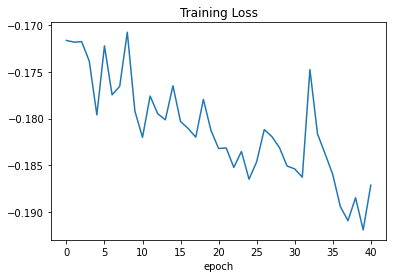

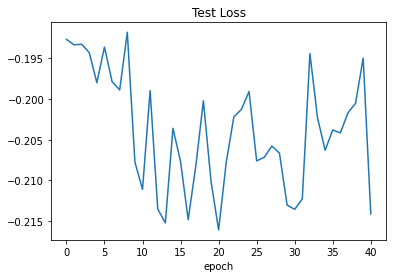

In [129]:
# Plot the training loss
plt.figure()
per_epoch_results.mean()["train"]["loss"]["network"].plot(title="Training Loss")

# Plot the test loss
plt.figure()
per_epoch_results.mean()["test"]["loss"]["network"].plot(title="Test Loss")
#per_epoch_results.mean()['test']['loss']['network'].plot()

In [130]:
network = network.eval()

In [131]:
# Assign benchmarks. Recall: IBM does poorly. Amazon does well.
# First add the individual stocks
benchmarks = {asset_name: Singleton(asset_ix=i) for i, asset_name in enumerate(asset_names_batch)}

# Now add the others
benchmarks["1overN"] = OneOverN()  # each asset has weight 1 / n_assets
benchmarks["random"] = Random()  # random allocation that is however close 1OverN
benchmarks["network"] = network  # our trained network

# Include metrics. Selected two, since using only one bombs out at time of writing
# NOTE: We are using `simple` here for the mean return, whereas most of the training and data config above is in log-space by default.
metrics = {
    "Sharpe": SharpeRatio(),
    "MeanReturn": MeanReturns(output_type="simple"),
    "MaxDD": MaximumDrawdown(),
}


In [132]:
metrics_table = generate_metrics_table(benchmarks, dataloader_test, metrics)

In [133]:
metrics_table['value'] *= -1

In [134]:
metrics_table.tail()

,timestamp,benchmark,metric,value
55,2020-09-09,network,MaxDD,-0.036913
56,2019-08-23,network,MaxDD,-0.003409
57,2020-06-30,network,MaxDD,-0.004989
58,2020-02-27,network,MaxDD,-0.047351
59,2019-01-17,network,MaxDD,-0.012100


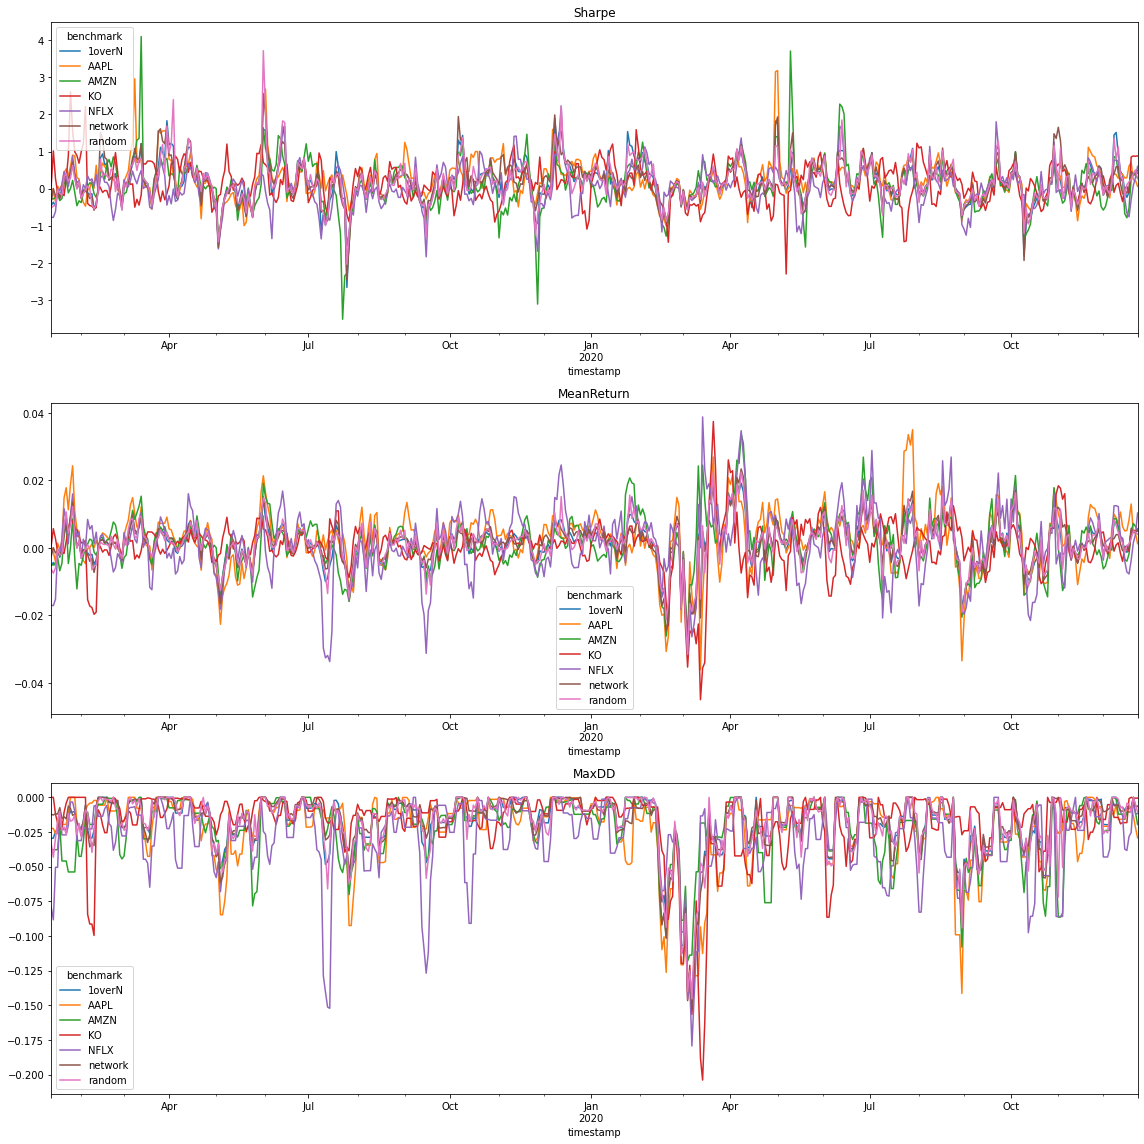

In [142]:
# Plot resulting metrics
# Note: this method doesn't accept a figure so we can't resize without assigning default figure size
plt.rcParams['figure.figsize'] = (16, 16)
plot_metrics(metrics_table)
plt.rcParams['figure.figsize'] = default_figsize

In [136]:
weight_table = generate_weights_table(network, dataloader_test)
weight_table

,AAPL,AMZN,KO,NFLX
2019-01-14,0.129013,0.139553,0.597675,0.133759
2019-01-15,0.132809,0.145919,0.579252,0.142019
2019-01-16,0.125351,0.135306,0.605628,0.133715
2019-01-17,0.126214,0.135849,0.603348,0.134589
2019-01-18,0.131864,0.142455,0.584483,0.141198
...,...,...,...,...
2020-12-17,0.306581,0.220251,0.241451,0.231717
2020-12-18,0.335375,0.209527,0.230666,0.224432
2020-12-21,0.336099,0.216835,0.217275,0.229791
2020-12-22,0.341435,0.203992,0.233235,0.221338


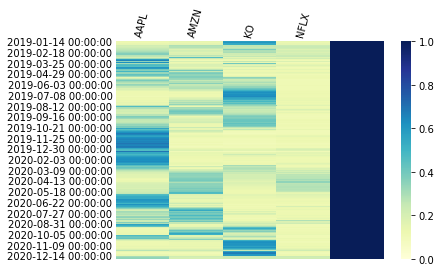

In [137]:
plot_weight_heatmap(weight_table,
                    add_sum_column=True,
                    time_format=None,
                    time_skips=25)

In [138]:
benchmark_num = metrics_table['benchmark'].unique()
metric_num = metrics_table['metric'].unique()

In [139]:
df2=pd.DataFrame(np.random.randn(len(benchmark_num),len(metric_num)),
                 index=list(benchmark_num),
                 columns=list(metric_num))
for i in benchmark_num:
  for j in metric_num:
    returns = metrics_table.query(f"(metric=='{j}') & (benchmark == '{i}')")
    index_num=list(benchmark_num).index(i)
    column_num=list(metric_num).index(j)
    df2.iloc[index_num][column_num]=returns['value'].mean()
    #print(index_num,column_num,returns['value'].mean())
print(df2)




           Sharpe  MeanReturn     MaxDD
AAPL     0.238337    0.002707 -0.022453
AMZN     0.114759    0.001489 -0.022167
KO       0.130506    0.000412 -0.018429
NFLX     0.062595    0.001124 -0.029963
1overN   0.192418    0.001427 -0.017555
random   0.197327    0.001464 -0.018279
network  0.214115    0.001571 -0.017348
